# Design a working controller

## 1. Set up the notebook

### 1.1 Do imports

In [2]:
import numpy as np
import sympy as sym
from scipy import linalg
import matplotlib.pyplot as plt
from ae483tools import *

### 1.2 Create autoencoders

Define a function to print code that implements linear state feedback.

In [3]:
def export_controller(K, s, i, s_with_des, i_eq,
                      decimals=8,
                      suffix='',
                      line_ending=''):
    """
    K is a gain matrix, of size m x n
    s is a list of states as symbolic variables, of length n
    i is a list of inputs as symbolic variables, of length m
    s_with_des is a list of states that have desired values, as
        symbolic variables - if there are no such states, then
        this should be an empty list []
    i_eq is a list of equilibrium values of inputs, of length m
    decimals is the number of decimals to include when printing
        each value
    suffix is the character (if any) to print after each number,
        for example 'f' to indicate a "float" when exporting to C
    line_ending is the character (if any) to print after each
        line, for example ';' when exporting to C
    """
    
    s_name = [scur.name for scur in s]
    i_name = [icur.name for icur in i]
    for row in range(len(i_name)):
        input_string = ''
        for col in range(len(s_name)):
            k = K[row, col]
            if not np.isclose(k, 0.):
                if (k < 0) and input_string:
                    input_string += ' +'
                if s[col] in s_with_des:
                    n = f'({s_name[col]} - {s_name[col]}_des)'
                else:
                    n = s_name[col]
                input_string += f' {-k:.{decimals}f}{suffix} * {n}'
        if not np.isclose(i_eq[row], 0.):
            if (i_eq[row] > 0) and input_string:
                input_string += ' +'
            input_string += f' {i_eq[row]:.{decimals}f}{suffix}'
        print(f'{i_name[row]} ={input_string}{line_ending}')

Define a function to print code that implements a method of power distribution.

In [4]:
def export_power_distribution(Pinv,
                              i=sym.symbols(['tau_x', 'tau_y', 'tau_z', 'f_z']),
                              m=sym.symbols(['m_1', 'm_2', 'm_3', 'm_4']),
                              limiter='self.limitUint16',
                              decimals=1,
                              suffix='',
                              line_ending=''):
    """
    Pinv is a 4 x 4 matrix that maps inputs to motor power commands
    i is a list of inputs as symbolic variables (by default, this list
        is ['tau_x', 'tau_y', 'tau_z', 'f_z'])
    m is a list of motor power commands as symbolic variables (by default,
        this list is ['m_1', 'm_2', 'm_3', 'm_4'])
    limiter is the name of the function to apply that ensures each
        motor power command is valid (i.e., an integer within bounds),
        for example "limitUint16" when exporting to C
    decimals is the number of decimals to include when printing
        each value
    suffix is the character (if any) to print after each number,
        for example 'f' to indicate a "float" when exporting to C
    line_ending is the character (if any) to print after each
        line, for example ';' when exporting to C
    """
    
    i_name = [icur.name for icur in i]
    m_name = [mcur.name for mcur in m]
    for row in range(len(m_name)):
        input_string = ''
        for col in range(len(i_name)):
            k = Pinv[row, col]
            if not np.isclose(k, 0.):
                if (k > 0) and input_string:
                    input_string += ' +'
                n = i_name[col]
                input_string += f' {k:.{decimals}f}{suffix} * {n}'
        print(f'{m_name[row]} = {limiter}({input_string} ){line_ending}')

### 1.3 Create an LQR solver

Define a function that solves the linear quadratic regulator (LQR) problem.

In [5]:
def lqr(A, B, Q, R):
    P = linalg.solve_continuous_are(A, B, Q, R)
    K = linalg.inv(R) @  B.T @ P
    return K

## 2. Derive equations of motion

### 2.1 Define symbolic variables

Define states.

In [6]:
# components of position (meters)
p_x, p_y, p_z = sym.symbols('p_x, p_y, p_z')

# yaw, pitch, and roll angles (radians)
psi, theta, phi = sym.symbols('psi, theta, phi')

# components of linear velocity (meters / second)
v_x, v_y, v_z = sym.symbols('v_x, v_y, v_z')

# components of angular velocity (radians / second)
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')

Define inputs.

In [7]:
# components of net rotor torque
tau_x, tau_y, tau_z = sym.symbols('tau_x, tau_y, tau_z')

# net rotor force
f_z = sym.symbols('f_z')

Define parameters.

In [8]:
m, J_x, J_y, J_z, g = sym.symbols('m, J_x, J_y, J_z, g')

Create the linear velocity vector $v^B_{W, B}$ and the angular velocity vector $w^B_{W, B}$, both written in the coordinates of the body frame.

In [9]:
v_inB_ofWB = sym.Matrix([v_x, v_y, v_z])
w_inB_ofWB = sym.Matrix([w_x, w_y, w_z])

Create moment of inertia matrix (in coordinates of the body frame).

In [10]:
J_inB = sym.diag(J_x, J_y, J_z)

### 2.2 Define kinematics of orientation

#### 2.2.1 Rotation matrix in terms of yaw, pitch, roll angles

Define individual rotation matrices.

In [11]:
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0],
                 [sym.sin(psi), sym.cos(psi), 0],
                 [0, 0, 1]])

Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)],
                 [0, 1, 0],
                 [-sym.sin(theta), 0, sym.cos(theta)]])

Rx = sym.Matrix([[1, 0, 0],
                 [0, sym.cos(phi), -sym.sin(phi)],
                 [0, sym.sin(phi), sym.cos(phi)]])

Apply sequential transformation to compute the rotation matrix that describes the orientation of the drone (i.e., of frame $B$ in the coordinates of frame $W$).

In [12]:
R_inW_ofB = Rz * Ry * Rx
R_inW_ofB

Matrix([
[cos(psi)*cos(theta), sin(phi)*sin(theta)*cos(psi) - sin(psi)*cos(phi),  sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi)],
[sin(psi)*cos(theta), sin(phi)*sin(psi)*sin(theta) + cos(phi)*cos(psi), -sin(phi)*cos(psi) + sin(psi)*sin(theta)*cos(phi)],
[        -sin(theta),                              sin(phi)*cos(theta),                               cos(phi)*cos(theta)]])

#### 2.2.2 Map from angular velocity to angular rates

Recall that

$$\begin{bmatrix} \dot{\psi} \\ \dot{\theta} \\ \dot{\phi} \end{bmatrix} = N w_{W, B}^{B}$$

for some matrix $N$. Here is how to compute that matrix for a ZYX (yaw, pitch, roll) Euler angle sequence.  First, we compute its inverse:

In [60]:
Ninv = sym.Matrix.hstack((Ry * Rx).T * sym.Matrix([0, 0, 1]),
                              (Rx).T * sym.Matrix([0, 1, 0]),
                                       sym.Matrix([1, 0, 0]))

Then, we compute $N$ by taking the inverse of $N^{-1}$:

In [61]:
N = sym.simplify(Ninv.inv())

### 2.3 Define equations of motion

Forces.

In [62]:
f_inB = R_inW_ofB.T * sym.Matrix([0, 0, -m * g]) + sym.Matrix([0, 0, f_z])

Torques.

In [63]:
tau_inB = sym.Matrix([tau_x, tau_y, tau_z])

Create equations of motion.

In [64]:
f_sym = sym.Matrix.vstack(
    R_inW_ofB * v_inB_ofWB,
    N * w_inB_ofWB,
    (1 / m) * (f_inB - w_inB_ofWB.cross(m * v_inB_ofWB)),
    J_inB.inv() * (tau_inB - w_inB_ofWB.cross(J_inB * v_inB_ofWB)),
)

Show the right-hand side of the equations of motion, which have the form

$$\dot{s} = f(s, i, p)$$

for states

$$
s = \begin{bmatrix} p_x \\ p_y \\ p_z \\ \psi \\ \theta \\ \phi \\ v_x \\ v_y \\ v_z \\ w_x \\ w_y \\ w_z \end{bmatrix},
$$

inputs
$$
i = \begin{bmatrix} \tau_x \\ \tau_y \\ \tau_z \\ f_z \end{bmatrix},
$$

and parameters
$$
p = \begin{bmatrix} m \\ J_x \\ J_y \\ J_z \\ g \end{bmatrix}.
$$

In [65]:
f_sym

Matrix([
[ v_x*cos(psi)*cos(theta) + v_y*(sin(phi)*sin(theta)*cos(psi) - sin(psi)*cos(phi)) + v_z*(sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi))],
[v_x*sin(psi)*cos(theta) + v_y*(sin(phi)*sin(psi)*sin(theta) + cos(phi)*cos(psi)) + v_z*(-sin(phi)*cos(psi) + sin(psi)*sin(theta)*cos(phi))],
[                                                                       -v_x*sin(theta) + v_y*sin(phi)*cos(theta) + v_z*cos(phi)*cos(theta)],
[                                                                                         w_y*sin(phi)/cos(theta) + w_z*cos(phi)/cos(theta)],
[                                                                                                               w_y*cos(phi) - w_z*sin(phi)],
[                                                                                   w_x + w_y*sin(phi)*tan(theta) + w_z*cos(phi)*tan(theta)],
[                                                                                                (g*m*sin(theta) + m*v_y*w_z - m*v_z*w_y)/m

## 3. Derive state-space model

### 3.1 Choose equilibrium point

An equilibrium point of the nonlinear system is a choice of states $s_\text{eq}$ and inputs $i_\text{eq}$ — along with constant parameters $p_\text{eq}$ — for which

$$0 = f(s_\text{eq}, i_\text{eq}, p_\text{eq}).$$

Create a list of states, inputs, and parameters as symbolic variables.

In [66]:
s = [p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z]
i = [tau_x, tau_y, tau_z, f_z]
p = [m, J_x, J_y, J_z, g]

Create a list of states to track as symbolic variables. These are states whose desired values will be specified by a client.

In [67]:
s_with_des = [p_x, p_y, p_z]

Create a function that evaluates $f(\cdot)$ at particular values of $s$, $i$, and $p$.

In [68]:
f = sym.lambdify(s + i + p, f_sym)

Define constants.

In [69]:
# Mass
m = 34/1000     # <-- FIXME

# Principle moments of inertia
J_x = 1.64e-05  # <-- FIXME
J_y = 1.70e-05  # <-- FIXME
J_z = 2.21e-05  # <-- FIXME

# Acceleration of gravity
g = 9.81

Create a list of parameter values in the **same order** as the symbolic list. These are the parameter estimates we found in our experiments. They are not choices. (We use the subscript `_eq` to be consistent with what follows, and could say "parameter values *at equilibrium*," but don't be misled. These parameter values are *given* and are *constant* - again, they aren't choices.)

In [70]:
p_eq = [m, J_x, J_y, J_z, g]

Create a list of state and input values at equilibrium in the **same order** as the symbolic lists.

In [71]:
s_eq = [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.] # <-- FIXME
i_eq = [0., 0., 0., m*g]                                 # <-- FIXME

Evaluate the equations of motion at the equilibrium point — if it actually *is* an equilibrium point, then the result should be an array of zeros:

In [72]:
print(f(*s_eq, *i_eq, *p_eq))
assert(np.allclose(f(*s_eq, *i_eq, *p_eq), 0.))

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


Note that this equilibrium point would remain an equilibrium point for any choice of `p_x`, `p_y`, and `p_z` — that is one thing that allows the controller to track desired values of these variables.

### 3.2 Compute A and B

We want to find

$$
A = \frac{\partial f}{\partial s}\biggr\vert_{(s, i, p) = (s_\text{eq}, i_\text{eq}, p_\text{eq})}
\qquad\text{and}\qquad
B = \frac{\partial f}{\partial i}\biggr\vert_{(s, i, p) = (s_\text{eq}, i_\text{eq}, p_\text{eq})}.
$$

First, we compute each Jacobian (i.e., each matrix of partial derivatives) in symbolic form.

In [73]:
A_sym = f_sym.jacobian(s)
B_sym = f_sym.jacobian(i)

Then, we create functions that allow us to evaluate these Jacobians at particular values of $s$, $i$, and $p$.

In [74]:
A_num = sym.lambdify(s + i + p, A_sym)
B_num = sym.lambdify(s + i + p, B_sym)

Finally, we plug in our equilibrium point.

In [75]:
A = A_num(*s_eq, *i_eq, *p_eq)
B = B_num(*s_eq, *i_eq, *p_eq)

Show $A$ (formatted nicely).

In [76]:
A_str = np.array2string(A,
                        formatter={'float_kind': lambda x: f'{x:6.3f}'},
                        prefix='    ',
                        max_line_width=np.inf)

print(f'A = {A_str}')

A = [[ 0.000  0.000  0.000  0.000  0.000  0.000  1.000  0.000  0.000  0.000  0.000  0.000]
     [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  1.000  0.000  0.000  0.000  0.000]
     [ 0.000  0.000  0.000  0.000 -0.000  0.000 -0.000  0.000  1.000  0.000  0.000  0.000]
     [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  1.000]
     [ 0.000  0.000  0.000  0.000  0.000 -0.000  0.000  0.000  0.000  0.000  1.000 -0.000]
     [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  1.000  0.000  0.000]
     [ 0.000  0.000  0.000  0.000  9.810  0.000  0.000  0.000 -0.000  0.000 -0.000  0.000]
     [ 0.000  0.000  0.000  0.000  0.000 -9.810 -0.000  0.000  0.000  0.000  0.000 -0.000]
     [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000 -0.000  0.000 -0.000  0.000  0.000]
     [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000 -0.000  0.000 -0.000  0.000]
     [ 0.000  0.000  0.000  0.000  0.000  0.000 -0.000  0.000  0.000  0.000  0.000 -0.000]

Show $B$ (formatted nicely).

In [77]:
B_str = np.array2string(B,
                        formatter={'float_kind': lambda x: f'{x:11.3f}'},
                        prefix='    ',
                        max_line_width=np.inf)

print(f'B = {B_str}')

B = [[      0.000       0.000       0.000       0.000]
     [      0.000       0.000       0.000       0.000]
     [      0.000       0.000       0.000       0.000]
     [      0.000       0.000       0.000       0.000]
     [      0.000       0.000       0.000       0.000]
     [      0.000       0.000       0.000       0.000]
     [      0.000       0.000       0.000       0.000]
     [      0.000       0.000       0.000       0.000]
     [      0.000       0.000       0.000      29.412]
     [  60975.610       0.000       0.000       0.000]
     [      0.000   58823.529       0.000       0.000]
     [      0.000       0.000   45248.869       0.000]]


The state-space system is described by

$$ \dot{x} = Ax + Bu $$

where

$$ x = s - s_\text{eq} $$

and

$$ u = i - i_\text{eq}. $$

Note that $A$ and $B$ would remain the same for any choice of `p_x`, `p_y`, and `p_z` — that is another thing that allows the controller to track desired values of these variables.

## 4. Design method of power distribution

Define constants.

In [78]:
k_F = 1.67e-6 # <-- FIXME
k_M = 3.96e-8 # <-- FIXME
l = 0.033   # <-- FIXME

Define the matrix $P$ that maps motor power commands ($m_1$, $m_2$, $m_3$, $m_4$) to inputs ($\tau_x$, $\tau_y$, $\tau_z$, $f_z$).

In [79]:
P = np.array([[ -l * k_F, -l * k_F,  l * k_F,  l * k_F  ],
              [ -l * k_F, l * k_F,   l * k_F,  -l * k_F ],
              [ -k_M,     k_M,       -k_M,     k_M      ],
              [ k_F,      k_F,       k_F,      k_F      ]])

Compute the matrix $P^{-1}$ that maps inputs to motor power commands.

In [80]:
Pinv = linalg.inv(P)

Show the matrix $P^{-1}$ (formatted nicely).

In [81]:
Pinv_str = np.array2string(Pinv,
                           formatter={'float_kind': lambda x: f'{x:12.1f}'},
                           prefix='         ',
                           max_line_width=np.inf)

print(f'inv(P) = {Pinv_str}')

inv(P) = [[  -4536381.8   -4536381.8   -6313131.3     149700.6]
          [  -4536381.8    4536381.8    6313131.3     149700.6]
          [   4536381.8    4536381.8   -6313131.3     149700.6]
          [   4536381.8   -4536381.8    6313131.3     149700.6]]


Print code that implements the method of power distribution in C (compare this code to $P^{-1}$).

In [82]:
export_power_distribution(
    Pinv,
    i=i,
    limiter='limitUint16',
    suffix='f',
    line_ending=';',
)

m_1 = limitUint16( -4536381.8f * tau_x -4536381.8f * tau_y -6313131.3f * tau_z + 149700.6f * f_z );
m_2 = limitUint16( -4536381.8f * tau_x + 4536381.8f * tau_y + 6313131.3f * tau_z + 149700.6f * f_z );
m_3 = limitUint16( 4536381.8f * tau_x + 4536381.8f * tau_y -6313131.3f * tau_z + 149700.6f * f_z );
m_4 = limitUint16( 4536381.8f * tau_x -4536381.8f * tau_y + 6313131.3f * tau_z + 149700.6f * f_z );


## 5. Design, implement, and test a sequence of controllers

### 5.x Flight test (template)

Choose the weighting matrices $Q$ and $R$.

In [83]:
# FIXME
Q = np.diag([
    1.,
    1.,
    1.,
    1.,
    1.,
    1.,
    1.,
    1.,
    1.,
    1.,
    1.,
    1.,
])

# FIXME
R = np.diag([
    1.,
    1.,
    1.,
    1.,
])

### 5.1 Flight test

In [84]:
c = 65535 - m*g/(4*k_F)
delta = c/4
print(delta)
# FIXME
Q = np.diag([
    1.,
    1.,
    1.,
    1.,
    1.,
    1.,
    1.,
    1.,
    1.,
    1.,
    1.,
    1.,
])

# FIXME
R = np.diag([
    (1/(4*k_F*l*delta))**2,
    (1/(4*k_F*l*delta))**2,
    (1/(4*k_M*delta))**2,
    (1/(m*g+4*k_F*delta))**2,
])

3900.9655688622734


5.2 Flight test: Trying to kill x drift

In [85]:
c = 65535 - m*g/(4*k_F)
delta = c/4
print(delta)
# FIXME
Q = np.diag([
    5.,
    1.,
    1.,
    1.,
    1.,
    1.,
    1.,
    1.,
    1.,
    1.,
    1.,
    1.,
])

# FIXME
R = np.diag([
    (1/(4*k_F*l*delta))**2,
    (1/(4*k_F*l*delta))**2,
    (1/(4*k_M*delta))**2,
    (1/(m*g+4*k_F*delta))**2,
])

3900.9655688622734


Find the gain matrix $K$.

In [86]:
K = lqr(A, B, Q, R)

Show $K$ (formatted nicely).

In [87]:
K_str = np.array2string(K,
                        formatter={'float_kind': lambda x: f'{x:8.5f}'},
                        prefix='    ',
                        max_line_width=np.inf)

print(f'K = {K_str}')

K = [[-0.00000 -0.00086 -0.00000  0.00000 -0.00000  0.00490 -0.00000 -0.00126  0.00000  0.00095 -0.00000 -0.00000]
     [ 0.00192 -0.00000 -0.00000  0.00000  0.00573  0.00000  0.00173 -0.00000 -0.00000 -0.00000  0.00097  0.00000]
     [ 0.00000  0.00000  0.00000  0.00062  0.00000 -0.00000  0.00000  0.00000  0.00000 -0.00000  0.00000  0.00064]
     [ 0.00000  0.00000  0.35960 -0.00000  0.00000 -0.00000  0.00000  0.00000  0.39213  0.00000 -0.00000  0.00000]]


Print code that implements the controller in C.

In [88]:
export_controller(
    K,               # the gain matrix
    s,               # list of states as symbolic variables
    i,               # list of inputs as symbolic variables
    s_with_des,      # list of states that have desired values as symbolic variables
    i_eq,            # list of equilibrium values of inputs
    suffix='f',      # character to print after each number (indicates a "float")
    line_ending=';'  # character to print after each line
)

tau_x = 0.00085993f * (p_y - p_y_des) -0.00489858f * phi + 0.00126423f * v_y -0.00094876f * w_x;
tau_y = -0.00192286f * (p_x - p_x_des) -0.00573397f * theta -0.00172838f * v_x -0.00096666f * w_y;
tau_z = -0.00061791f * psi -0.00063963f * w_z;
f_z = -0.35959845f * (p_z - p_z_des) -0.39212720f * v_z + 0.33354000f;


Load and resample data.

In [89]:
# Load data
raw_data_drone, raw_data_mocap = load_hardware_data(
    'hardware_data_x.json',     # <-- FIXME
)

# Resample data
data_drone = resample_data_drone(
    raw_data_drone,
    t_min_offset=0.,            # <-- FIXME
    t_max_offset=0.,            # <-- FIXME
)

FileNotFoundError: [Errno 2] No such file or directory: 'hardware_data_x.json'

Parse data.

In [90]:
# time
t = data_drone['time']

# position
p_x = data_drone['ae483log.p_x']
p_y = data_drone['ae483log.p_y']
p_z = data_drone['ae483log.p_z']

# desired position
p_x_des = data_drone['ae483log.p_x_des']
p_y_des = data_drone['ae483log.p_y_des']
p_z_des = data_drone['ae483log.p_z_des']

# orientation
psi = data_drone['ae483log.psi']
theta = data_drone['ae483log.theta']
phi = data_drone['ae483log.phi']

# motor power commands
m_1 = data_drone['ae483log.m_1']
m_2 = data_drone['ae483log.m_2']
m_3 = data_drone['ae483log.m_3']
m_4 = data_drone['ae483log.m_4']

NameError: name 'data_drone' is not defined

Plot position, desired position, orientation, and motor power commands.

NameError: name 't' is not defined

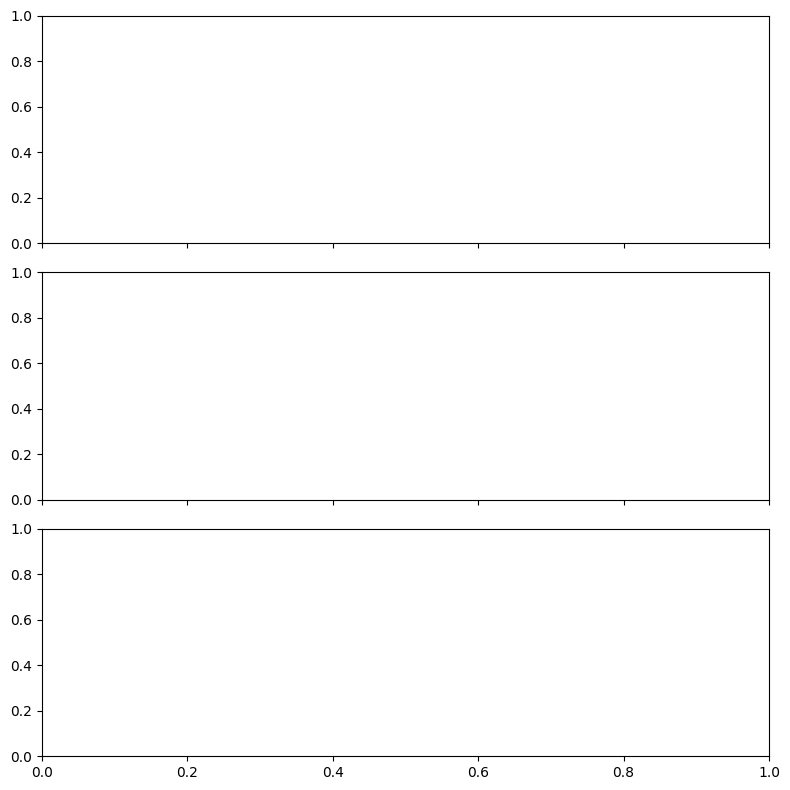

In [91]:
fig, (ax_pos, ax_ori, ax_pow) = plt.subplots(3, 1, figsize=(8, 8), sharex=True, tight_layout=True)
px = ax_pos.plot(t, p_x, label=f'p_x')
py = ax_pos.plot(t, p_y, label=f'p_y')
pz = ax_pos.plot(t, p_z, label=f'p_z')
ax_pos.plot(t, p_x_des, '--', label=f'p_x (desired)', color=px[0].get_color())
ax_pos.plot(t, p_y_des, '--', label=f'p_y (desired)', color=py[0].get_color())
ax_pos.plot(t, p_z_des, '--', label=f'p_z (desired)', color=pz[0].get_color())
ax_pos.legend()
ax_pos.grid()
ax_ori.plot(t, psi, label='psi')
ax_ori.plot(t, theta, label='theta')
ax_ori.plot(t, phi, label='phi')
ax_ori.legend()
ax_ori.grid()
ax_pow.plot(t, m_1, label='m_1')
ax_pow.plot(t, m_2, label='m_2')
ax_pow.plot(t, m_3, label='m_3')
ax_pow.plot(t, m_4, label='m_4')
ax_pow.legend()
ax_pow.grid()
ax_pow.set_xlabel('time (s)')
plt.show()

**Modify this cell** to describe three things:

* Your design, in particular your choice of $Q$ and $R$ (e.g., why did you make the choices you did).
* Your flight test, in particular your choice of flight trajectory (in words and with relevant code from `flight.py`) and the flight conditions (where was the flight conducted, did you power cycle the drone just before flying, what was the battery level, were you using the active marker deck, etc.).
* Your results (as shown in the plots), in particular your hypotheses about the cause of any failures (e.g., crashed drone) and about what might be done to improve performance.

Please also make clear (with justification) whether or not you believe the results obtained in this flight test are "good enough."